In [3]:
import os
import re
import h5py

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io 

import utils

In [4]:
datadir = '../datasets/NNN/'
fnames = utils.fnames(datadir)

for pair in fnames:
    gus_fname = os.path.join(datadir, pair[0])
    proc_fname = os.path.join(datadir, pair[1])
    
    proc_data = scipy.io.loadmat(proc_fname)
    
    print(proc_data.keys())
    break

dict_keys(['__header__', '__version__', '__globals__', 'B_SI', 'F_SI', 'O_SI', 'UnitNum', 'UnitType', 'best_r_time1', 'best_r_time2', 'mean_psth', 'pos', 'r_search_pool', 'reliability_basic', 'reliability_best', 'reliability_find_testset', 'response_basic', 'response_best', 'snr', 'snrmax'])


In [60]:
datadir = '../datasets/NNN/'
gus_fnames = [f for f in os.listdir(datadir) if re.match(r'^GoodUnit.*\.mat$', f)]

session_num = 0

with h5py.File(os.path.join(datadir,  fnames[0][0]), 'r') as f:
    # print(f.keys())
    ras = f['GoodUnitStrc/Raster']
    img_idx = f['meta_data/trial_valid_idx']
    psth = f['GoodUnitStrc/response_matrix_img']
        
    # Dereference all cell elements into a list of np arrays
    # Note: use raster[i] instead of raster[i, 0] if it's 1D
    raster_npy = [f[ras[i,0]][()] for i in range(ras.shape[0])]
    psth_npy = [f[psth[i,0]][()] for i in range(psth.shape[0])]
    
    # get rid of failed trials (0 image indices)
    img_idx = np.array(img_idx)
    img_idx = img_idx[img_idx != 0]
    
    raster = np.stack(raster_npy)
    emp_psth = np.stack(psth_npy)

# shape is (711, 450, 5720) --> (units, time point, trials)
print(raster.shape, emp_psth.shape, img_idx.shape)

(456, 450, 7434) (456, 450, 1072) (7434,)


Text(0.5, 1.0, 'PSTH for unit 0')

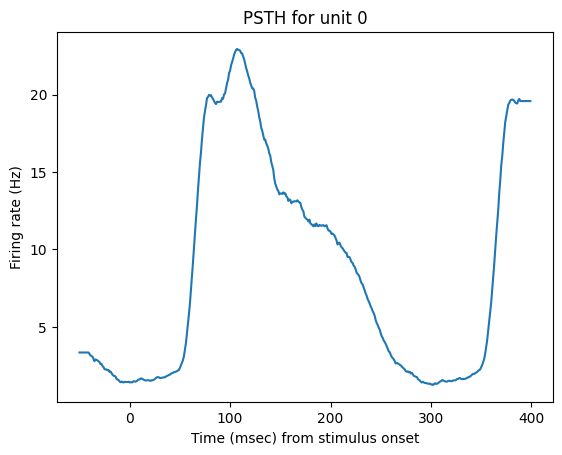

In [126]:
# PSTH plot, computed by li
# averaged over image repeats, then over all images

unit_idx = 0  # first unit

t = np.arange(raster.shape[1]) - 50
fr = emp_psth.mean(axis=2)[unit_idx]
# print(emp_psth.shape, emp_psth.mean(axis=2).shape, emp_psth.mean(axis=2)[0].shape)

plt.plot(t, fr)
plt.xlabel("Time (msec) from stimulus onset")
plt.ylabel("Firing rate (Hz)")
plt.title(f"PSTH for unit {unit_idx}")

In [56]:
proc_fnames = [f for f in os.listdir(datadir) if re.match(r'^Processed.*\.mat$', f)]

session_num = 0

data = loadmat(os.path.join(datadir, proc_fnames[session_num]))
f_dprime = data['F_SI']
avg_spikes = data['response_basic']

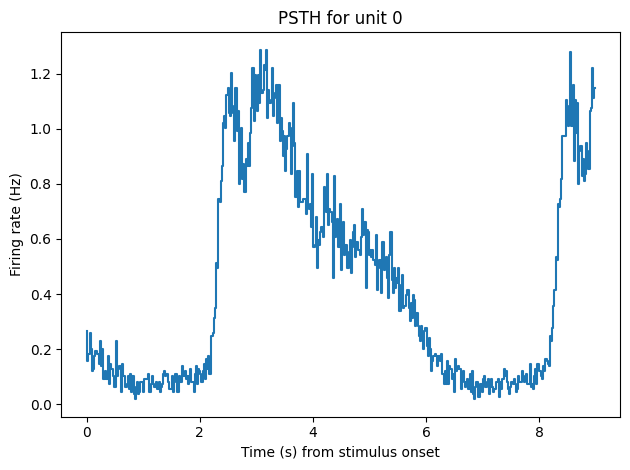

In [115]:
unit_idx = 0  # PSTH for first unit
psth = raster[unit_idx].mean(axis=1)  # mean across trials

bin_size = 0.02  # 10 ms
t = np.arange(raster.shape[1]) * bin_size

plt.step(t, psth / bin_size, where='mid')
plt.xlabel("Time (s) from stimulus onset")
plt.ylabel("Firing rate (Hz)")
plt.title(f"PSTH for unit {unit_idx}")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'PSTH for unit 0')

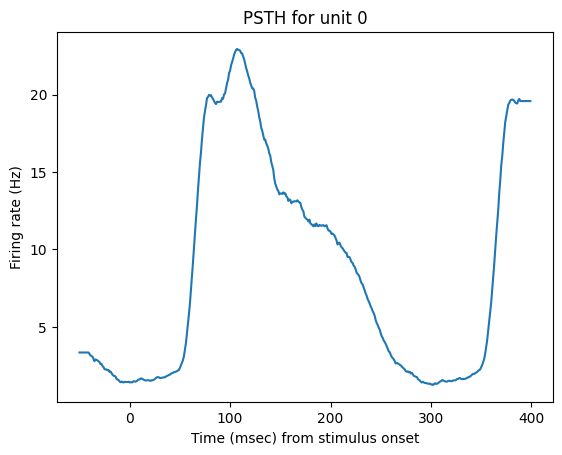

In [128]:
t = np.arange(raster.shape[1]) - 50
emp_psth.mean(axis=2)[0].shape

plt.plot(t, emp_psth.mean(axis=2)[0])
plt.xlabel("Time (msec) from stimulus onset")
plt.ylabel("Firing rate (Hz)")
plt.title(f"PSTH for unit {unit_idx}")

In [111]:
def mat_struct_to_dict(f, obj):
    """
    Recursively convert HDF5 Matlab structure/group or dataset to nested dicts and numpy arrays.
    Automatically dereferences cell arrays and groups.
    """
    result = {}
    for key in obj.keys():
        item = obj[key]
        # If subgroup, recurse
        if isinstance(item, h5py.Group):
            result[key] = mat_struct_to_dict(f, item)
        # If dataset, check if cell array (object refs) or regular array
        elif isinstance(item, h5py.Dataset):
            # Cell arrays: h5py Datasets where dtype == object or ref
            if item.dtype == 'O' or h5py.check_dtype(ref=item.dtype) is not None:
                cell_data = []
                item = np.squeeze(item)  # optional; you can keep this or not
                for idx in np.ndindex(item.shape):
                    ref = item[idx]
                    if isinstance(ref, (np.ndarray,)):
                        ref = ref.item()
                    if isinstance(f[ref], h5py.Group):
                        arr = mat_struct_to_dict(f, f[ref])
                    else:
                        arr = f[ref][()]
                    cell_data.append(arr)
                try:
                    cell_data = np.array(cell_data, dtype=object).reshape(item.shape)
                except Exception as e:
                    print(f'{key} data is ragged or shape is weird: {e}. Returning as a list of arrays.')
                result[key] = cell_data
            else:
                # Standard numeric array (possibly needs squeezing)
                result[key] = item[()]
    return result

def load_mat(filename):
    """
    Load a Matlab -v7.3 (HDF5-format) .mat file, dereference cell arrays, and
    return a dict of numpy arrays and nested dicts (for group/structs).
    """
    with h5py.File(filename, 'r') as f:
        data = {}
        for key in f.keys():
            obj = f[key]
            if key.startswith('#'):
                continue
            print(key, type(obj))
            if isinstance(obj, h5py.Group):
                data[key] = mat_struct_to_dict(f, obj)
            elif isinstance(obj, h5py.Dataset):
                # Top-level cell array or dataset
                if obj.dtype == 'O' or h5py.check_dtype(ref=obj.dtype) is not None:
                    cell_data = []
                    indices = np.ndindex(obj.shape)
                    for idx in indices:
                        ref = obj[idx]
                        if isinstance(ref, (np.ndarray,)):
                            ref = ref.item()
                        arr = f[ref][()]
                        cell_data.append(arr)
                    cell_data = np.array(cell_data, dtype=object).reshape(obj.shape)
                    data[key] = cell_data
                else:
                    data[key] = obj[()]
        return data

In [6]:
datadir = '../datasets/NNN/'
fname = os.path.join(datadir, fnames[0][0])
data = utils.load_mat(fname)